# Path Tracing Notebook
Implementation of Light Transport Algorithms

********************************************************************************************

In [1]:
import taichi as ti
ti.init(arch=ti.cpu, debug=True, random_seed=36279)

[Taichi] version 1.6.0, llvm 15.0.7, commit f1c6fbbd, osx, python 3.11.4


[I 08/27/24 11:27:56.306 9738195] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=arm64


In [2]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from taichi.math import vec3, cross, normalize

In [3]:
original_cornell_box = "../objects/cornell_box/CornellBox-Original.obj"
empty_cornell_box = "../objects/cornell_box/empty.obj"
cornell_box_sphere = "../objects/cornell_box/CornellBox-Sphere.obj"
test_scene = "../objects/untitled.obj"


obj_path = test_scene
mtl_path = obj_path.replace('.obj', '.mtl')

In [4]:
from utils.mesh import parse_scene, extract_material_data_from_mesh
import pyvista as pv

pv.set_jupyter_backend('trame')


vertices, faces, material_data = parse_scene(obj_path)

# Print material data
print("Material Data:")
print(material_data)

# Print vertices
print("\nVertices:")
print(vertices)

# Print faces
print("\nFaces Array:")
print(faces)

# Now you can load vertices and faces_array into PyVista
# Example:
mesh = pv.PolyData(vertices, faces)


# Attach all material properties to the mesh
mesh.cell_data['face_idx'] = material_data['face_idx']
mesh.cell_data['diffuse'] = material_data['diffuse']
mesh.cell_data['ambient'] = material_data['ambient']
mesh.cell_data['specular'] = material_data['specular']
mesh.cell_data['emission'] = material_data['emission']
mesh.cell_data['shininess'] = material_data['shininess']
mesh.cell_data['ior'] = material_data['ior']
mesh.cell_data['opacity'] = material_data['opacity']
mesh.cell_data['illum'] = material_data['illum']
mesh.cell_data['is_light'] = material_data['is_light']

# Triangulate the mesh
triangulated_mesh = mesh.triangulate()

# Extract material data from the triangulated mesh
material_data = extract_material_data_from_mesh(triangulated_mesh)

# Print extracted material data to verify
print(material_data)



# Create the left mirror sphere
left_sphere_center = (-0.31, 0.495, 0.175)
left_sphere_radius = 0.495
left_sphere = pv.Sphere(radius=left_sphere_radius, center=left_sphere_center)

# Create the right transparent glass sphere
right_sphere_center = (0.49, 0.245, -0.225)
right_sphere_radius = 0.245
right_sphere = pv.Sphere(radius=right_sphere_radius, center=right_sphere_center)



# Visualize the triangulated mesh to check if colors are mapped properly
plotter = pv.Plotter()


# Set the initial camera position and focal point
plotter.camera_position = 'xy'  # Align the camera view


plotter.add_mesh(triangulated_mesh, scalars='diffuse', rgb=True, show_edges=True)


# Add the spheres to the plotter
plotter.add_mesh(left_sphere, color='silver', specular=1.0, smooth_shading=True)  # Mirror-like sphere
plotter.add_mesh(right_sphere, color='white', opacity=0.5, smooth_shading=True)  # Transparent sphere


# Reset the camera to automatically fit the scene
plotter.reset_camera()  # This does what "Reset camera" in the GUI does

# Show the plotter window
plotter.show()

# Extract the updated camera parameters after resetting the camera
camera_position = plotter.camera_position[0]  # Camera position
camera_focal_point = plotter.camera_position[1]  # Look-at point
camera_up_vector = plotter.camera.up  # Up direction

# Convert these to numpy arrays or Taichi vectors as needed
_position = np.array(camera_position)
_look_at = np.array(camera_focal_point)
_up = np.array(camera_up_vector)


Unimplemented OBJ format statement 'g' on line 'g CornellBox-Empty-CO_CornellBox-Empty-CO'
Unimplemented OBJ format statement 's' on line 's 0'
Unimplemented OBJ format statement 'g' on line 'g CornellBox-Empty-CO_floor'
Unimplemented OBJ format statement 'g' on line 'g CornellBox-Empty-CO_ceiling'
Unimplemented OBJ format statement 'g' on line 'g CornellBox-Empty-CO_backWall'
Unimplemented OBJ format statement 'g' on line 'g CornellBox-Empty-CO_rightWall'
Unimplemented OBJ format statement 'g' on line 'g CornellBox-Empty-CO_leftWall'
Unimplemented OBJ format statement 'g' on line 'g CornellBox-Empty-CO_light'
/Users/dipanjan/LightTransportSimulator/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/Users/dipanjan/LightTransportSimulator/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subn

Material Data:
[(0, [0.885809 , 0.698859 , 0.666422 ], [1., 1., 1.], [0., 0., 0.], [ 0.     ,  0.     ,  0.     ], 10.000005, 1. , 1., 2, 0)
 (1, [0.885809 , 0.698859 , 0.666422 ], [1., 1., 1.], [0., 0., 0.], [ 0.     ,  0.     ,  0.     ], 10.000005, 1. , 1., 2, 0)
 (0, [0.885809 , 0.698859 , 0.666422 ], [1., 1., 1.], [0., 0., 0.], [ 0.     ,  0.     ,  0.     ], 10.000005, 1. , 1., 2, 0)
 (1, [0.885809 , 0.698859 , 0.666422 ], [1., 1., 1.], [0., 0., 0.], [ 0.     ,  0.     ,  0.     ], 10.000005, 1. , 1., 2, 0)
 (0, [0.885809 , 0.698859 , 0.666422 ], [1., 1., 1.], [0., 0., 0.], [ 0.     ,  0.     ,  0.     ], 10.000005, 1. , 1., 2, 0)
 (1, [0.885809 , 0.698859 , 0.666422 ], [1., 1., 1.], [0., 0., 0.], [ 0.     ,  0.     ,  0.     ], 10.000005, 1. , 1., 2, 0)
 (0, [0.570068 , 0.0430135, 0.0443706], [1., 1., 1.], [0., 0., 0.], [ 0.     ,  0.     ,  0.     ], 10.000005, 1.5, 1., 2, 0)
 (1, [0.570068 , 0.0430135, 0.0443706], [1., 1., 1.], [0., 0., 0.], [ 0.     ,  0.     ,  0.     ], 10.

Widget(value='<iframe src="http://localhost:62483/index.html?ui=P_0x1693760d0_0&reconnect=auto" class="pyvista…

In [5]:
_position, _look_at, _up

(array([-0.01      ,  0.995     ,  6.71198469]),
 array([-0.01 ,  0.995, -0.025]),
 array([0., 1., 0.]))

In [6]:
print(triangulated_mesh.center)

[-0.010000000000000009, 0.995, -0.025000000000000022]


In [7]:
# Example: Check how many faces have illum=7
illum_1 = material_data[material_data['illum'] == 1].shape[0]
illum_2 = material_data[material_data['illum'] == 2].shape[0]
illum_5 = material_data[material_data['illum'] == 5].shape[0]
illum_7 = material_data[material_data['illum'] == 7].shape[0]

# Number of faces with illum=7
total_faces = material_data.shape[0]

# Print the result
print(total_faces==(illum_1+illum_2+illum_5+illum_7))
print(total_faces, illum_1, illum_2, illum_5, illum_7)

True
12 2 10 0 0


In [8]:
# Extract vertices
vertices = triangulated_mesh.points.astype(np.float32)
n_vertices = vertices.shape[0]

# Extract faces directly after triangulation
faces = triangulated_mesh.faces.reshape(-1, 4)[:, 1:4]  # Reshape and remove the first column (number of points per face)
faces = faces.astype(np.int32)
n_faces = faces.shape[0]

n_triangles = n_faces

n_lights = illum_1  # assumed emissive surfaces have illum=2

print(n_triangles, n_faces, n_vertices)

12 12 24


In [9]:
# Create Taichi fields
vertices_field = ti.Vector.field(3, dtype=ti.f32, shape=(n_vertices,))
faces_field = ti.Vector.field(3, dtype=ti.i32, shape=(n_faces,))

vertices_field.from_numpy(vertices)
faces_field.from_numpy(faces)

In [10]:
# from primitives.triangle import Triangle
#
# # Create a Taichi field for the triangles
# TS = ti.root.dense(ti.i, n_triangles)
# triangles = Triangle.field()
# TS.place(triangles)

In [11]:
n_spheres = 2 # will describe later
n_primitives = n_triangles + n_spheres

In [12]:
from primitives.primitives import Sphere

if n_spheres==0:
    sphere_field_size = 1
else:
    sphere_field_size = n_spheres

SS = ti.root.dense(ti.i, sphere_field_size)
spheres = Sphere.field()  # shape=(n_spheres)
SS.place(spheres)

<ti.SNode of type dense>

In [13]:
from base.materials import Material

# Create a Taichi field for the materials

MS = ti.root.dense(ti.i, n_triangles)
materials = Material.field()
MS.place(materials)

<ti.SNode of type dense>

In [14]:
from primitives.primitives import Primitive

# Create a Taichi field for the materials
PS = ti.root.dense(ti.i, n_primitives)
primitives = Primitive.field()
PS.place(primitives)

<ti.SNode of type dense>

In [15]:
from base.lights import DiffuseAreaLight

# Create a Taichi field for light sources
LS = ti.root.dense(ti.i, n_lights)
lights = DiffuseAreaLight.field()
LS.place(lights)

<ti.SNode of type dense>

In [16]:
# Extract the 'face_idx' field
face_idx = material_data['face_idx']

# Check if all 'face_idx' values are unique
are_unique = len(face_idx) == len(np.unique(face_idx))

print("All face_idx are unique:", are_unique)

All face_idx are unique: True


In [17]:
len(material_data) == n_primitives

False

In [18]:
materials.from_numpy(material_data)

In [19]:
materials[11]['face_idx'] == 11

True

In [20]:
lights.shape

(2,)

In [21]:
from utils.misc import max_component
from base.bsdf import BXDF_DIFFUSE_REFLECTION, BXDF_SPECULAR_REFLECTION, BXDF_DIFFUSE_TRANSMISSION, BXDF_SPECULAR_TRANSMISSION

@ti.kernel
def populate_shapes():
    light_idx = 0
    for i in range(primitives.shape[0]-n_spheres):
        # Set up the geometry for the primitive (triangle in this case)
        primitives[i].triangle.vertex_1 = vertices_field[faces_field[i][0]]
        primitives[i].triangle.vertex_2 = vertices_field[faces_field[i][1]]
        primitives[i].triangle.vertex_3 = vertices_field[faces_field[i][2]]
        primitives[i].triangle.centroid = (primitives[i].triangle.vertex_1 + primitives[i].triangle.vertex_2 + primitives[i].triangle.vertex_3) / 3.0
        primitives[i].triangle.edge_1 = primitives[i].triangle.vertex_2 - primitives[i].triangle.vertex_1
        primitives[i].triangle.edge_2 = primitives[i].triangle.vertex_3 - primitives[i].triangle.vertex_1
        primitives[i].triangle.normal = normalize(cross(primitives[i].triangle.edge_1, primitives[i].triangle.edge_2))

        # Initialize the BSDF frame
        # primitives[i].bsdf.init_frame(primitives[i].triangle.normal)

        primitives[i].bsdf.diffuse.type = 0
        primitives[i].bsdf.transmit.type = 1
        primitives[i].bsdf.dielectric.type = 2
        primitives[i].bsdf.conductor.type = 3
        primitives[i].bsdf.mirror.type = 4
        primitives[i].bsdf.specular.type = 5

        # Determine the BxDF type based on material properties
        illum = materials[i].illum

        # if illum == 0 or illum == 1:  # Diffuse materials
        #     primitives[i].bsdf.add_diffuse(materials[i].diffuse)
        # elif illum == 2:  # Diffuse + Specular (using Conductor BxDF for specular)
        #     roughness = 1.0 - (materials[i].shininess / 1000.0)
        #     primitives[i].bsdf.add_conductor(materials[i].diffuse, vec3(0.0), roughness)
        # elif illum == 3:  # Diffuse + Specular + Reflection (using Conductor BxDF)
        #     roughness = 1.0 - (materials[i].shininess / 1000.0)
        #     primitives[i].bsdf.add_conductor(materials[i].diffuse, vec3(0.0), roughness)
        # elif illum == 4 or illum == 6:  # Transparent materials (Dielectric BxDF)
        #     primitives[i].bsdf.add_dielectric(materials[i].ior, 0.0)  # Assume perfectly smooth dielectric
        # elif illum == 5 or illum == 7:  # Mirror reflection (using Conductor BxDF)
        #     primitives[i].bsdf.add_conductor(vec3(1.5), vec3(0.0), 0.0)  # Perfectly smooth conductor
        # else:  # Default to Diffuse
        #     primitives[i].bsdf.add_diffuse(materials[i].diffuse)

        if illum == 1 or illum == 2:  # Diffuse materials
            primitives[i].bsdf.add_diffuse(materials[i].diffuse)
        if illum == 5:  # Mirror materials
            primitives[i].bsdf.add_mirror(materials[i].specular)
        elif illum == 6:  # Metals (using Conductor BxDF)
            eta_silver = vec3(0.155, 0.116, 0.138)
            k_silver = vec3(4.828, 3.122, 2.146)
            roughness = 0.0
            primitives[i].bsdf.add_conductor(eta_silver, k_silver, roughness)
        elif illum == 7:  # Transparent materials (Dielectric BxDF)
            primitives[i].bsdf.add_dielectric(materials[i].ior, materials[i].specular, 0.1)  # Assume perfectly smooth dielectric
        else:  # Default to Diffuse
            primitives[i].bsdf.add_diffuse(materials[i].diffuse)


        # Handle emissive materials (lights)
        if max_component(materials[i].emission) > 0:
            primitives[i].is_light = 1
            primitives[i].light_idx = light_idx
            lights[light_idx].shape_idx = i  # Link the light to the primitive
            lights[light_idx].two_sided = 0  # Assuming lights are one-sided
            lights[light_idx].Le = materials[i].emission
            light_idx += 1
        else:
            primitives[i].is_light = 0

        # Assign material to the primitive
        primitives[i].material = materials[i]

        # Set the shape type, assuming 0 is for triangle
        primitives[i].shape_type = 0

        if materials[i].face_idx == i:
            primitives[i].material = materials[i]
        else:
            print("face mismatch!!")

    print("Shapes populated:", primitives.shape[0])


# Call the kernel to populate the triangles
populate_shapes()

Shapes populated: 14


In [22]:
@ti.kernel
def add_spheres():

    # Define the BSDF types for easy reference
    primitives[n_triangles].bsdf.diffuse.type = 0
    primitives[n_triangles].bsdf.transmit.type = 1
    primitives[n_triangles].bsdf.dielectric.type = 2
    primitives[n_triangles].bsdf.conductor.type = 3
    primitives[n_triangles].bsdf.mirror.type = 4
    primitives[n_triangles].bsdf.specular.type = 5

    # Add the left mirror sphere (Positioned on the left side of the box)
    primitives[n_triangles].shape_type = 1  # 1 indicates a sphere
    primitives[n_triangles].sphere.center = vec3([-0.31, 0.495, 0.175])
    primitives[n_triangles].sphere.radius = 0.495
    # primitives[n_triangles].sphere.center = vec3([-0.41, 0.395, -0.225])
    # primitives[n_triangles].sphere.radius = 0.4
    primitives[n_triangles].is_light = 0

    # Set up the material for the left mirror sphere
    primitives[n_triangles].material.diffuse = vec3([0.03, 0.03, 0.03])
    primitives[n_triangles].material.specular = vec3([0.999, 0.999, 0.999])
    primitives[n_triangles].material.emission = vec3([0.0, 0.0, 0.0])
    primitives[n_triangles].material.shininess = 1024.0
    primitives[n_triangles].material.ior = 1.0
    primitives[n_triangles].material.opacity = 1.0
    primitives[n_triangles].material.is_light = 0

    eta_silver = vec3(0.155, 0.116, 0.138)
    k_silver = vec3(4.828, 3.122, 2.146)
    roughness = 0.0

    # Set up the BSDF for the left mirror sphere
    primitives[n_triangles].bsdf.add_conductor(eta_silver, k_silver, roughness)



    # Define the BSDF types for easy reference
    primitives[n_triangles + 1].bsdf.diffuse.type = 0
    primitives[n_triangles + 1].bsdf.transmit.type = 1
    primitives[n_triangles + 1].bsdf.dielectric.type = 2
    primitives[n_triangles + 1].bsdf.conductor.type = 3
    primitives[n_triangles + 1].bsdf.mirror.type = 4
    primitives[n_triangles + 1].bsdf.specular.type = 5

    # Add the right transparent glass sphere (Positioned on the right side of the box)
    primitives[n_triangles + 1].shape_type = 1  # 1 indicates a sphere
    primitives[n_triangles + 1].sphere.center = vec3([0.49, 0.245, -0.225])
    primitives[n_triangles + 1].sphere.radius = 0.245
    # primitives[n_triangles + 1].sphere.center = vec3([0.49, 0.395, 0.175])
    # primitives[n_triangles + 1].sphere.radius = 0.4
    primitives[n_triangles + 1].is_light = 0  # Not a light source

    # Set up the material for the right transparent glass sphere
    primitives[n_triangles + 1].material.diffuse = vec3([0.01, 0.01, 0.01])
    primitives[n_triangles + 1].material.specular = vec3([0.999, 0.999, 0.999])
    primitives[n_triangles + 1].material.emission = vec3([0.0, 0.0, 0.0])
    primitives[n_triangles + 1].material.shininess = 1024.0
    primitives[n_triangles + 1].material.ior = 1.5
    primitives[n_triangles + 1].material.opacity = 0.1
    primitives[n_triangles + 1].material.is_light = 0

    # Set up the BSDF for the right transparent glass sphere
    primitives[n_triangles + 1].bsdf.add_dielectric(primitives[n_triangles + 1].material.ior, primitives[n_triangles + 1].material.specular, 0.0)
    # primitives[n_triangles + 1].bsdf.add_specular(primitives[n_triangles + 1].material.specular, primitives[n_triangles + 1].material.ior)

# Assuming `primitives` and `n_triangles` are defined globally
add_spheres()


In [23]:
primitives[n_triangles].bsdf.type

3

In [24]:
lights[0].shape_idx

10

In [25]:
# p_min = np.min(vertices)
# p_max = np.max(vertices)
#
# # centroid = vec3(bbox_center)
# centroid = mesh.center
#
# min_p = ti.field(dtype=ti.f32, shape=())
# min_p[None] = p_min
#
# centroid, min_p[None]

In [26]:
from primitives.aabb import AABB, BVHPrimitive

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
BS = ti.root.dense(ti.i, n_primitives)
bvh_primitives = BVHPrimitive.field()
BS.place(bvh_primitives)

@ti.kernel
def init_bounded_boxes():
    for i in ti.ndrange(n_primitives):
        bvh_primitives[i].prim = primitives[i]
        bvh_primitives[i].prim_num = i
        min_p, max_p = primitives[i].get_bounds()
        centroid = (min_p+max_p)/2
        bvh_primitives[i].bounds = AABB(min_point=min_p, max_point=max_p, centroid=centroid)

init_bounded_boxes()

bvh_primitives.shape[0], n_primitives

(14, 14)

In [27]:
# bounded_boxes[3]

In [28]:
OPS = ti.root.dense(ti.i, n_primitives)
ordered_prims = Primitive.field()
OPS.place(ordered_prims)

<ti.SNode of type dense>

In [29]:
from accelerators.bvh import BVHNode, BucketInfo

node_idx = 0

BVS = ti.root.dense(ti.i, 3 * n_primitives)
nodes = BVHNode.field()
BVS.place(nodes)


<ti.SNode of type dense>

In [30]:
nodes.shape[0]

42

In [31]:

total_nodes = ti.field(ti.i32, shape=())
split_method = ti.field(ti.i32, shape=())
start = ti.field(ti.i32, shape=())
end = ti.field(ti.i32, shape=())
ordered_prims_idx = ti.field(ti.i32, shape=())
stack_ptr = ti.field(ti.i32, shape=())
# ordered_prims_size = ti.field(ti.i32, shape=())

@ti.kernel
def init_stack():
    total_nodes[None] = 0
    split_method[None] = 0
    start[None] = 0
    end[None] = n_primitives
    ordered_prims_idx[None] = 0
    stack_ptr[None] = 0
    # ordered_prims_size[None] = 0

init_stack()

In [32]:
stack = ti.field(ti.i32, shape=(3*n_primitives, 4))
n_buckets = 12
buckets = BucketInfo.field(shape=(n_buckets))
costs = ti.field(dtype=ti.f32, shape=(n_buckets-1))

In [33]:
primitives.shape[0], bvh_primitives.shape[0], start[None], end[None], ordered_prims.shape[0], nodes.shape[0], total_nodes[None], split_method[None], stack.shape, stack_ptr[None], ordered_prims_idx[None], costs.shape[0], buckets.shape[0]

(14, 14, 0, 14, 14, 42, 0, 0, (42, 4), 0, 0, 11, 12)

In [34]:
from accelerators.bvh import build_bvh

start_t = time.time()

build_bvh(primitives, bvh_primitives, start, end, ordered_prims, nodes, total_nodes, split_method, stack, stack_ptr, ordered_prims_idx, costs, buckets)

end_t = time.time()

In [35]:
print("Elapsed (with compilation) = %s" % (end_t - start_t))
print(f"Total Nodes: {total_nodes}")

Elapsed (with compilation) = 0.4092738628387451
Total Nodes: 25


In [36]:
total_nodes[None]

25

In [37]:
from accelerators.bvh import LinearBVHNode
from accelerators.bvh import flatten_bvh

# create a linear representation of the bvh tree (empty)

LBVS = ti.root.dense(ti.i, total_nodes[None])
linear_bvh = LinearBVHNode.field()
LBVS.place(linear_bvh)

stack_size = 2 * n_primitives - 1  # Maximum possible stack size
stack3 = ti.Vector.field(3, dtype=ti.i32, shape=stack_size)
stack_top_2 = ti.field(dtype=ti.i32, shape=())

start_t = time.time()
total_nodes = flatten_bvh(nodes, linear_bvh, 0, stack3, stack_top_2)
end_t = time.time()
print(f"Total flattened nodes: {total_nodes}")

Total flattened nodes: 25


In [38]:
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 0.027623891830444336


In [39]:
position = ti.Vector(_position.tolist()) # centroid + vec3([0.0, 0.0, min_p[None]*3])
look_at = ti.Vector(_look_at.tolist()) # normalize(centroid - position)
up = ti.Vector(_up.tolist()) # vec3([0.0, 1.0, 0.0])

In [40]:
from taichi.math import radians, tan
from base.frame import Frame, frame_from_z
from base.camera import PerspectiveCamera

camera = PerspectiveCamera.field(shape=())

width = 256
height = 256

# zoomed_position = ti.Vector.field(3, dtype=ti.f32, shape=())
# fov = ti.field(ti.f32, shape=())
# aspect_ratio = ti.field(ti.f32, shape=())
# lens_radius = ti.field(ti.f32, shape=())
# focal_distance = ti.field(ti.f32, shape=())
# screen_dx = ti.field(ti.f32, shape=())
# screen_dy = ti.field(ti.f32, shape=())
# dx_camera = ti.Vector.field(3, dtype=ti.f32, shape=())
# dy_camera = ti.Vector.field(3, dtype=ti.f32, shape=())
# frame = Frame.field(shape=())

@ti.kernel
def init_cam():
    camera.width[None] = width
    camera.height[None] = height
    camera.fov[None] = 30.0
    camera.aspect_ratio[None] = width / float(height)
    camera.lens_radius[None] = 0.00  # Set to a small value like 0.01 to test depth of field
    camera.focal_distance[None] = (look_at - position).norm()

    direction = (look_at - position).normalized()
    zoom_factor = 1.5  # + in / - out
    camera.position[None] = position + direction * zoom_factor

    # Setup the camera frame (z points towards the scene)
    z = (look_at - camera.position[None]).normalized()
    camera.frame[None] = frame_from_z(z)

    theta = radians(camera.fov[None])
    half_height = tan(theta / 2)
    half_width = camera.aspect_ratio[None] * half_height

    # Compute the screen dimensions in camera space
    camera.screen_dx[None] = 2 * half_width
    camera.screen_dy[None] = 2 * half_height

    # Compute the pixel size in camera space
    camera.dx_camera[None] = ti.Vector([camera.screen_dx[None] / width, 0.0, 0.0])
    camera.dy_camera[None] = ti.Vector([0.0, camera.screen_dy[None] / height, 0.0])


init_cam()

In [41]:
camera.frame[None]

{'x': [1.0, 0.0, 0.0], 'y': [0.0, -1.0, 0.0], 'z': [0.0, 0.0, -1.0]}

In [42]:
@ti.kernel
def test_camera():
    # Generate a ray
    s, t = 0.5, 0.5  # Center of the screen
    ray_origin, ray_dir, rx_origin, rx_dir, ry_origin, ry_dir = camera[None].generate_ray_differential(s, t)
    print(ray_origin, ray_dir, rx_origin, rx_dir, ry_origin, ry_dir)

test_camera()

[-0.010000, 0.995000, 5.211985] [0.000000, 0.000000, -1.000000] [-0.010000, 0.995000, 5.211985] [0.002093, 0.000000, -0.999998] [-0.010000, 0.995000, 5.211985] [0.000000, -0.002093, -0.999998]


In [43]:
from base.scene import Scene

pt = 0
mis = 1

# Instantiate a Scene object with the Camera object
scene = Scene(integrator=pt, spp=256, max_depth=6, sample_lights=1, sample_bsdf=1)

In [44]:
from base.render import render

# Initialize the image field outside the kernel using the actual values
image = ti.Vector.field(3, dtype=ti.f32, shape=(camera[None].width, camera[None].height))


start_t = time.time()

# Call the render_scene kernel
render(scene, image, lights, camera[None], primitives, linear_bvh)

end_t = time.time()

print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 65.8245849609375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


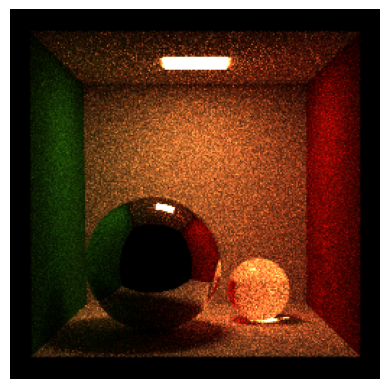

In [45]:
image_np = image.to_numpy()
# if np.isnan(image_np).any() or np.isinf(image_np).any():
#     print("Warning: NaN or Inf values detected in the image")
# image_np = np.clip(image_np, 0, 1)  # Clip values between 0 and 1
plt.imshow(image_np)
plt.axis('off')
plt.show()

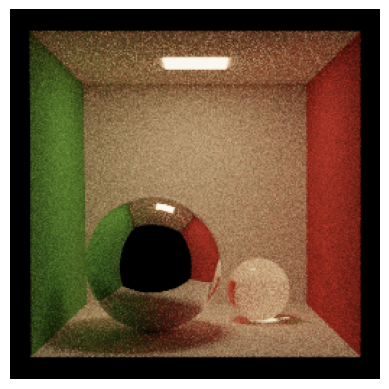

In [46]:
def tone_mapping(hdr_image, gamma=2.2):
    ldr_image = hdr_image / (1.0 + hdr_image)
    ldr_image = np.power(ldr_image, 1.0 / gamma)
    return np.clip(ldr_image, 0, 1)

ldr_image = tone_mapping(image_np)

# Display the tone-mapped image
plt.imshow(ldr_image)
plt.axis('off')
plt.show()